# RANSAC

Jól ismert tény, hogy a hagyományos legkisebb négyzetek módszere alapján történő modell paraméter becslés nem rezisztens, vagyis igen érzékeny az adatokban esetlegesen előforduló durva hibákra. Akár már egyetlen durva hibás adat is képes összeomlasztani a becslést, ami azt jelenti, hogy a meghatározott paraméterek torzítása akár tetszőlegesen nagy lehet.

Ezen a problémán segít a **RANSAC (RANdom Sample And Consensus)** eljárás, amelyet Fischler és Bolles vezetett be 1981-ben. Ők egy olyan probléma megoldására alkalmazták, amikor a kiinduló adathalmaz nagy számú durva hibás értéket tartalmazott. A RANSAC által tolerálható durva hibás adatok aránya akár 50% is lehet.

A RANSAC tehát rezisztens iterációs paraméterbecslési eljárás, mely az adatok valamely modellre illeszkedő részhalmazából végzi a becslést. Mindegyik iterációs lépés az alábbiakat tartalmazza:

1. Az összes adatból válasszunk ki véletlen módon minimális számút és ellenőrizzük, hogy a kiválasztott adathalmaz érvényes-e?
2. Végezzük el a modell becslését és ellenőrizzük, hogy a modell érvényes-e?
3. Osztályozzuk az adatokat illeszkedő és kivágó adatokra a modelltől vett eltéréseik alapján - a megadott küszöbértéknél kisebb eltérésű pontokat tekintjük illeszkedő adatoknak.
4. Jegyezzük meg a modellt, ha az illeszkedő adatok száma a pillanatnyi maximum. Ha az adatok száma ugyanannyi, akkor az eltérések összege a döntő.

Ezeket a lépéseket egy megadott maximális számig végezzük el, illetve míg valamelyik speciális leállási feltétel nem teljesül. A legjobb modell becslését a korábbiakban meghatározott legjobb modell alapján végezzük el.

## Ellipszis illesztés RANSAC eljárással

A módszert egy egyszerű példán fogjuk bemutatni.

Állítsunk elő egy ellipszisre közelítőleg illeszkedő, konform adatokat:

In [1]:
import numpy as np
t = np.linspace(0, 2 * np.pi, 50)
a = 10
b = 5
xc = 20
yc = 30
theta = np.pi/6
x = xc + a*np.cos(theta)*np.cos(t) - b*np.sin(theta)*np.sin(t)
y = yc + a*np.sin(theta)*np.cos(t) + b*np.cos(theta)*np.sin(t)
data = np.column_stack([x, y])
# reprodukálható eredmények miatt:
np.random.seed(seed=1234)
data += np.random.normal(size=data.shape)

Legyenek hibás (kivágó) adataink is:

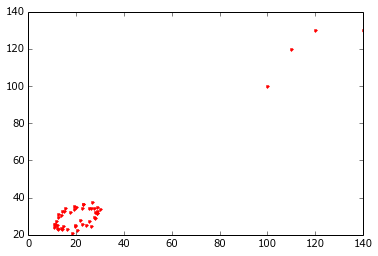

In [2]:
data[0] = (100, 100)
data[1] = (110, 120)
data[2] = (120, 130)
data[3] = (140, 130)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(data[:,0],data[:,1],'r.')
plt.show()

### Végezzünk becslést teljes legkisebb négyzetek módszerével

A becsléshez a [Scikit-image](http://scikit-image.org)  képfeldolgozó programkönyvtárat használjuk. Azért ezt, mert ebben megtalálható a legkisebb négyzetek szerinti becslés mellett a RANSAC eljárás megvalósítása is, így azt nem nekünk kell megírnunk. 

In [3]:
import skimage.measure as sm
model = sm.EllipseModel()
model.estimate(data)
# a meghatározott modell ellipszis paraméterek
# xc, yc, a, b, theta
np.set_printoptions(suppress=True)
model._params

array([ 153.07820102,  151.12731802,  192.07191972,    5.99740512,
          0.73236567])

Ezek a paraméterek láthatóan teljesen rosszak. Az eredeti ellipszis fél tengelyhosszai 10 és 5 voltak, a középpont pedig az $O(20,30)$ koordinátájú pont.

### Végezzünk becslést RANSAC eljárással

In [5]:
# minimum 5 pont kell az általános ellipszis illesztéshez
n_min = 5
# illeszkedő pont maximális távolsága
t_max = 3.0
ransac_model, inliers = sm.ransac(data, sm.EllipseModel, n_min, t_max, max_trials=50)
print ransac_model._params
original_params = np.array([xc,yc,a,b,theta])
print original_params - ransac_model._params

[ 19.93423634  29.61139154   9.78907655   4.98747605   0.45201316]
[ 0.06576366  0.38860846  0.21092345  0.01252395  0.07158562]


A megtalált konform adatok pedig az 'inliers' tömb logikai 'igaz' értékű elemei:

In [6]:
inliers

array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

Jól látszik, hogy az első négy adat a kivágó, amit elrontottunk.

### Rajzoljuk fel a konform adatokra illeszkedő ellipszist

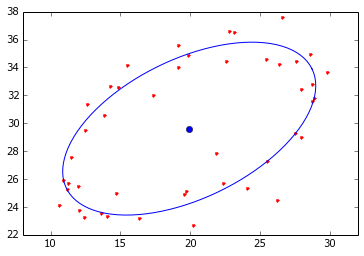

In [7]:
t = np.linspace(0, 2 * np.pi, 100)
p = ransac_model._params
xe = p[0] + p[2]*np.cos(p[4])*np.cos(t) - p[3]*np.sin(p[4])*np.sin(t)
ye = p[1] + p[2]*np.sin(p[4])*np.cos(t) + p[3]*np.cos(p[4])*np.sin(t)
plt.clf()
plt.plot(data[inliers,0],data[inliers,1],'r.')
plt.plot(xe,ye,'b-')
plt.plot(p[0],p[1],'bo')
plt.axis('equal')
plt.show()

A továbbiakban először lézer szkenneres adatok alapján meghatározzuk egy referencia gömb helyzetét és sugarát ([SphRANSAC](https://nbviewer.jupyter.org/github/gyulat/Korszeru_matek/blob/master/SphRANSAC.ipynb)). Ezután egy bonyolultabb geometriai feladatot oldunk meg: adott, durva hibás adatokat tartalmazó ponthalmaz alapján meghatározzuk egy legjobban illeszkedő egyenes körhenger paramétereit ([CylRANSAC](https://nbviewer.jupyter.org/github/gyulat/Korszeru_matek/blob/master/CylRANSAC.ipynb)).